In [12]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [19]:
from pprint import pprint
import typing
from typing import Optional, List

###############################################################################
#                    DataManager to load data from h5 file                    #
###############################################################################

# Access data like so:
# DM.data["wedge_filtered_brightness_temp_boxes"]
# DM.data["brightness_temp_boxes"]
# DM.data["ionized_boxes"]
# DM.data["redshifts"]
# DM.data["predicted_brightness_temp_boxes"]


class DataManager():

    """
    Loads data from h5py file. Once a DataManager object is loaded, you can
    access the data like so:
         ... = DM.data["wedge_filtered_brightness_temp_boxes"]
         ... = DM.data["brightness_temp_boxes"]
         ... = DM.data["ionized_boxes"]
         ... = DM.data["redshifts"]
         ... = DM.data["predicted_brightness_temp_boxes"]
    Metadata is stored in DM.metadata
    """

    def __init__(self, filepath: str):
        assert filepath[-3:] == ".h5", "filepath must point to an h5 file."

        self.filepath = filepath
        self.metadata = {}
        self.data = {}

        self.load_data_from_h5()
        

    def load_data_from_h5(self):
        """
        Loads coeval boxes from h5py file. Assumes h5py file has 5 datasets,
        'brightness_temp_boxes' -- ground truth brightness temp boxes 
        'wedge_filtered_brightness_temp_boxes' -- brightness temp boxes minus wedge
        'predicted_brightness_temp_boxes' -- predicted brightness temp from model
        'ionized_boxes' -- ionized boxes corresponding to brightness temp box
        'redshifts' --> redshift of each brightness temp box
        """

        with h5py.File(self.filepath, "r") as hf:

            # Check we have the required datasets
            datasets = list(hf.keys())
            assert "wedge_filtered_brightness_temp_boxes" in datasets and \
                   "brightness_temp_boxes" in datasets and \
                   "ionized_boxes" in datasets and \
                   "redshifts" in datasets, \
                   "Failed to extract datasets from h5py file."

            for k in hf.keys():
                v = np.array(hf[k][:], dtype=np.float32)
                assert np.isnan(np.sum(v)) == False
                self.data[k] = v
            self.data["redshifts"].reshape(-1) 

            # Load metadata from h5 file
            for k, v in hf.attrs.items():
                self.metadata[k] = v

        # Print success message
        print("\n----------\n")
        print(f"data loaded from {self.filepath}")
        print("Contents:")
        for k, v in self.data.items():
            print("\t{}, shape: {}".format(k, v.shape))
        print("\nMetadata:")
        pprint(self.metadata)
        print("\n----------\n")


###############################################################################
#                                   Example                                   #
###############################################################################
def example(DM: DataManager):
    redshifts = DM.data["redshifts"]
    bt_boxes = DM.data["brightness_temp_boxes"]
    wf_bt_boxes = DM.data["wedge_filtered_brightness_temp_boxes"]
    ionized_boxes = DM.data['ionized_boxes']

    # Binarize the ground truth and lightcones. 
    # Ground truth threshold is ALWAYS 0. 
    binarized_ground_truth = (bt_boxes > 0).astype(np.float32)
    #binarized_predictions = (wf_bt_boxes > 0.5).astype(np.float32)

    true_nfracs = binarized_ground_truth.sum(axis=(1,2,3)) / bt_boxes[0].size
    #predicted_nfracs = binarized_predictions.sum(axis=(1,2,3)) / bt_boxes[0].size

    for i, z in enumerate(redshifts):
        print("Redshift: ", z)
        print("\t Ground truth neutral fraction: {}".format(true_nfracs[i]))

if __name__ == "__main__":

    filepath = '/users/jacobkennedy/Desktop/PHYS_459/Github/wedge-repos/outputs/test.h5'
    DM = DataManager(filepath)

    example(DM)

# We need to transpose all xH_box, brightness_temperature for both predicted and ground truth

gt_ion_box_unT = DM.data['ionized_boxes']
gt_ion_box = np.array([gt_ion_box_unT[i].T for i in range(np.shape(gt_ion_box_unT)[0])])


----------

data loaded from /users/jacobkennedy/Desktop/PHYS_459/Github/wedge-repos/outputs/test.h5
Contents:
	brightness_temp_boxes, shape: (1, 128, 128, 128)
	ionized_boxes, shape: (1, 128, 128, 128)
	redshifts, shape: (1,)
	wedge_filtered_brightness_temp_boxes, shape: (1, 128, 128, 128)

Metadata:
{'p21c_initial_conditions': "{'user_params': {'HII_DIM': 128, 'BOX_LEN': 128}, "
                            "'random_seed': 42242}"}

----------

Redshift:  8.0
	 Ground truth neutral fraction: 0.6426424980163574


In [14]:
def plot_slice(box,n_xyz=(0,None,None),fig=None,ax=None):
    if (ax is None) and (fig is None):
        fig,ax = plt.subplots(figsize=[8,8])
    if isinstance(n_xyz[0], int):
        ax.imshow(box[n_xyz[0],:,:], cmap='Greys', origin='lower')
        ax.set_ylabel('z-axis [Mpc]', fontsize=30)
        ax.set_xlabel('x-axis [Mpc]', fontsize=30)
    elif isinstance(n_xyz[1], int):
        ax.imshow(box[:,n_xyz[1],:], cmap='Greys', origin='lower')
        ax.set_ylabel('z-axis [Mpc]', fontsize=30)
        ax.set_xlabel('x-axis [Mpc]', fontsize=30)
    else:
        ax.imshow(box[:,:,n_xyz[2]], cmap='Greys', origin='lower')
        ax.set_ylabel('y-axis [Mpc]', fontsize=30)
        ax.set_xlabel('x-axis [Mpc]', fontsize=30)
    ax.tick_params(axis='both',labelsize=15);
    return fig, ax

(<Figure size 576x576 with 1 Axes>,
 <AxesSubplot:xlabel='x-axis [Mpc]', ylabel='z-axis [Mpc]'>)

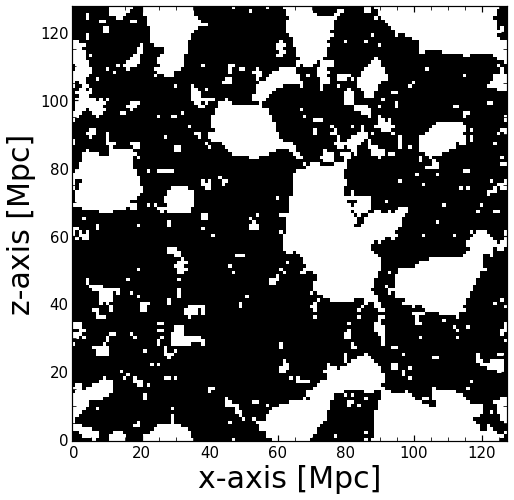

In [22]:
gt_ion_box_binarized = (gt_ion_box[0] > 0.9).astype(np.float32)
plot_slice(gt_ion_box_binarized)